In [11]:
import alpaca_backtrader_api
import backtrader as bt
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
#to plot within notebook
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [2]:
ALPACA_API_KEY ="PK8SSSXD3FX164IYREJ5"
ALPACA_SECRET_KEY ="NPKEgtQyt3fsRodbOqn4d46V19XI5W9S8Cv64dDT"
ALPACA_PAPER = True

In [3]:
from alpaca_trade_api.rest import REST, TimeFrame
api = REST(ALPACA_API_KEY,
           ALPACA_SECRET_KEY,
           'https://paper-api.alpaca.amrkets'
          )

data = api.get_bars("AAPL", TimeFrame.Day, "2019-11-15", "2021-11-15", adjustment='raw').df
# new_data = pd.DataFrame(index=range(0,len(data)),columns=['timestamp', 'close'])
# new_data

In [4]:
symbol = 'SPY'
bar = api.get_barset(symbol, 'day', limit=730)

c = []
t = []
idx = []

for i in range(len(bar[symbol])):
    temp_c = c.append(bar[symbol][i].c) 
    temp_t = t.append(bar[symbol][i].t)
    temp_idx = idx.append(i)
    i = i + 1

df_bar_t = pd.DataFrame(t, idx,columns = ['Datetime'])
df_bar_c = pd.DataFrame(c, idx, columns = ['Close'])

new_data = pd.merge(df_bar_t,df_bar_c, left_index = True, right_index = True)
new_data

,Datetime,Close
0,2019-01-10 00:00:00-05:00,258.94
1,2019-01-11 00:00:00-05:00,258.76
2,2019-01-14 00:00:00-05:00,257.69
3,2019-01-15 00:00:00-05:00,260.21
4,2019-01-16 00:00:00-05:00,260.94
...,...,...
725,2021-11-24 00:00:00-05:00,469.37
726,2021-11-26 00:00:00-05:00,459.03
727,2021-11-29 00:00:00-05:00,464.63
728,2021-11-30 00:00:00-05:00,455.78


In [5]:
def add_nextdate(data):
    date=data.iloc[-1][0]
    price_fake= data.iloc[-1][1]
    date_n=date+timedelta(days=1)
    data.loc[len(data.index)]=[date_n,price_fake]
    print(data)
add_nextdate(new_data)

                     Datetime   Close
0   2019-01-10 00:00:00-05:00  258.94
1   2019-01-11 00:00:00-05:00  258.76
2   2019-01-14 00:00:00-05:00  257.69
3   2019-01-15 00:00:00-05:00  260.21
4   2019-01-16 00:00:00-05:00  260.94
..                        ...     ...
726 2021-11-26 00:00:00-05:00  459.03
727 2021-11-29 00:00:00-05:00  464.63
728 2021-11-30 00:00:00-05:00  455.78
729 2021-12-01 00:00:00-05:00  450.53
730 2021-12-02 00:00:00-05:00  450.53

[731 rows x 2 columns]


In [22]:
#creating dataframe
symbol = 'SPY'
bar = api.get_barset(symbol, 'day', limit=730)

c = []
t = []
idx = []

for i in range(len(bar[symbol])):
    temp_c = c.append(bar[symbol][i].c) 
    temp_t = t.append(bar[symbol][i].t)
    temp_idx = idx.append(i)
    i = i + 1

df_bar_t = pd.DataFrame(t, idx,columns = ['Date'])
df_bar_c = pd.DataFrame(c, idx, columns = ['Close'])

new_data = pd.merge(df_bar_t,df_bar_c, left_index = True, right_index = True)
add_nextdate(new_data)
 
#change index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
 
#creating train and test sets
dataset = new_data.values
 
train = dataset[0:511,:]
valid = dataset[511:,:]
 
#converting dataset into X_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

#--------------------------

X_train, y_train = [], []
for i in range(60,len(train)):
    X_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
 
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
 
# add LSTM network
model = Sequential([
    layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)), 
    layers.Dropout(0.2),
    layers.LSTM(units = 50),
    layers.Dropout(0.2),
    # layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)),
    # layers.Dropout(0.2),
    layers.Dense(units = 1)
    ])
 
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=2)

 
#using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
 
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
 
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

                         Date   Close
0   2019-01-10 00:00:00-05:00  258.94
1   2019-01-11 00:00:00-05:00  258.76
2   2019-01-14 00:00:00-05:00  257.69
3   2019-01-15 00:00:00-05:00  260.21
4   2019-01-16 00:00:00-05:00  260.94
..                        ...     ...
726 2021-11-26 00:00:00-05:00  459.03
727 2021-11-29 00:00:00-05:00  464.63
728 2021-11-30 00:00:00-05:00  455.78
729 2021-12-01 00:00:00-05:00  450.53
730 2021-12-02 00:00:00-05:00  450.53

[731 rows x 2 columns]
Epoch 1/15
15/15 - 5s - loss: 0.0435 - 5s/epoch - 346ms/step
Epoch 2/15
15/15 - 1s - loss: 0.0074 - 695ms/epoch - 46ms/step
Epoch 3/15
15/15 - 1s - loss: 0.0054 - 1s/epoch - 79ms/step
Epoch 4/15
15/15 - 1s - loss: 0.0049 - 801ms/epoch - 53ms/step
Epoch 5/15
15/15 - 1s - loss: 0.0046 - 820ms/epoch - 55ms/step
Epoch 6/15
15/15 - 1s - loss: 0.0039 - 1s/epoch - 69ms/step
Epoch 7/15
15/15 - 1s - loss: 0.0040 - 700ms/epoch - 47ms/step
Epoch 8/15
15/15 - 1s - loss: 0.0042 - 682ms/epoch - 45ms/step
Epoch 9/15
15/15 - 1s - 

In [23]:
# error calculation 
rms = np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

6.221821473918822

/var/folders/63/s_dlyjvx16z1cy0sqjdr_z840000gn/T/ipykernel_4872/433897990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


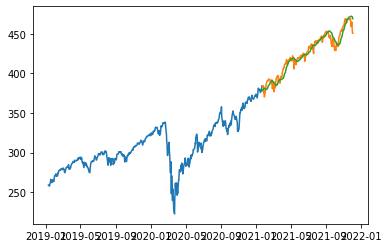

In [24]:
train = new_data[:511]
valid = new_data[511:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

In [26]:
# predict how the closing price changes tomorrow
def nextday_predict(data):
    change = data.iloc[-1][0]-data.iloc[-1][1]
    return f"Today's closing price has changed by {change} compared with yesterday"

change = nextday_predict(valid)
print(change)

Today's closing price has changed by -18.433348388671902 compared with yesterday
